In [1]:
%load_ext dotenv
%dotenv -o

import os
os.environ["POLYGON_DATA_DIR"]

'/media/mirror/files.polygon.io'

In [2]:
from zipline_polygon_bundle.config import PolygonConfig
from zipline_polygon_bundle import date_to_path, trades_schema, cast_trades, custom_aggs_schema, custom_aggs_partitioning, generate_csv_trades_tables, trades_to_custom_aggs
from zipline_polygon_bundle import get_custom_aggs_dates
from zipline_polygon_bundle import get_ticker_universe

from typing import Iterator, Tuple
import warnings

import pandas as pd
import plotly.graph_objs as go

import pyarrow as pa
from pyarrow import dataset as pa_ds
from pyarrow import compute as pa_compute
from pyarrow import compute as pc
from pyarrow import parquet as pa_parquet

from fsspec.implementations.arrow import ArrowFSWrapper

import os

import datetime
import pandas_market_calendars
import numpy as np

import resource

from itables import show

In [3]:
if not "POLYGON_TICKERS_DIR" in os.environ:
    os.environ["POLYGON_TICKERS_DIR"]= "/home/jovyan/data/tickers"

if not "CUSTOM_ASSET_FILES_DIR" in os.environ:
    os.environ["CUSTOM_ASSET_FILES_DIR"]= "/home/jovyan/data"

config = PolygonConfig(
    environ=os.environ,
    calendar_name="NYSE",
    start_date="2018-01-01",
    end_date="2023-12-31",
    agg_time="1min",
)

pd.set_option('display.width', 250)

print(f"{config.minute_aggs_dir=}")
print(f"{config.trades_dir=}")
print(f"{config.custom_aggs_dir=}")
print(f"{config.aggs_dir=}")
print(f"{config.by_ticker_dir=}")

config.minute_aggs_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/minute_aggs_v1'
config.trades_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/trades_v1'
config.custom_aggs_dir='/home/jovyan/data/60sec_aggs'
config.aggs_dir='/home/jovyan/data/60sec_aggs'
config.by_ticker_dir='/home/jovyan/data/60sec_aggs_by_ticker'


In [4]:
ticker_universe = get_ticker_universe(config, fetch_missing=True)
ticker_universe

tickers_csv_path='/home/jovyan/data/tickers/tickers_2018-01-01_2023-12-31.csv'
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49789 entries, ('CpP', 'XNYS', '0000831001', 'PFD', nan, True) to ('ZZrw', 'XNYS', '0000748015', 'RIGHT', nan, False)
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   start_date        49789 non-null  datetime64[ns]
 1   end_date          49789 non-null  datetime64[ns]
 2   last_updated_utc  49789 non-null  object        
 3   name              49789 non-null  object        
 4   share_class_figi  49789 non-null  object        
 5   delisted_utc      49789 non-null  object        
 6   currency_name     49789 non-null  object        
 7   locale            49789 non-null  object        
 8   market            49789 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 6.3+ MB


,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,
CpP,XNYS,0000831001,PFD,NaN,True,2018-01-02,2018-01-02,2024-12-03,[Citigroup Inc],[],[],[usd],[us],[stocks]
XKII,ARCX,0001081019,NaN,BBG00JHNY9Z4,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Intelligent Structures ETF],[BBG00JHNYBP0],[],[usd],[us],[stocks]
XKST,ARCX,0001081019,NaN,BBG00JHP5PG6,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Smart Mobility ETF],[BBG00JHP5Q56],[],[usd],[us],[stocks]
LDRS,ARCX,0001415726,NaN,UNKNOWN,True,2018-01-02,2018-01-02,2024-12-03,[Innovator IBD� ETF Leaders ETF],[UNKNOWN],[],[usd],[us],[stocks]
XKFS,ARCX,0001081019,NaN,BBG00JHP6203,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Future Security ETF],[BBG00JHP62Q5],[],[usd],[us],[stocks]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOEV,XNAS,0001750153,CS,BBG00NBK0GC3,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Class A Common Stock],[BBG00NBK0H68],[],[usd],[us],[stocks]
GOEVW,XNAS,0001750153,WARRANT,BBG00NWRF3R2,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Warrant],[],[],[usd],[us],[stocks]
GOEX,ARCX,0001432353,ETF,BBG0018HBWX2,True,2018-01-02,2023-12-29,2024-12-03,[Global X Gold Explorers ETF (NEW)],[BBG001TF8DG8],[],[usd],[us],[stocks]


In [5]:
ticker_universe[ticker_universe.index.get_level_values('ticker').str.contains("TEST")].sort_index()

,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,
ATEST,XASE,0001415311,NaN,BBG000Q2HK03,False,2018-01-02,2023-12-29,2016-10-25,[None],[BBG001S6X7W6],[2016-10-25],[usd],[us],[stocks]
ATEST.A,XASE,NaN,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
ATEST.B,XASE,0000849998,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
ATEST.C,XASE,0000860188,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST,XNYS,0001515980,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.A,XNYS,0001566897,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.B,XNYS,0000807884,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.C,XNYS,0000805264,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]


In [6]:
valid_tickers = pa.array([ticker for ticker in ticker_universe.index.get_level_values('ticker').to_list() if "TEST" not in ticker])
len(valid_tickers)

49781

In [4]:
def label_ticker_session(df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    # df.info()
    df = df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


# def label_ticker_day_aggs(df: pd.DataFrame, sessions: pd.Series):
#     pre_df = label_ticker_session(df, start=sessions['pre'], end=sessions['market_open'] - pd.Timedelta(seconds=60))
#     market_df = label_ticker_session(df, start=sessions['market_open'], end=sessions['market_close'] - pd.Timedelta(seconds=60))
#     post_df = label_ticker_session(df, start=sessions['market_close'], end=sessions['post'] - pd.Timedelta(seconds=60))
#     return pd.concat([pre_df, market_df, post_df])


def label_custom_aggs_for_date(sessions, aggs_df):
    def label_custom_aggs(df: pd.DataFrame):
        # ticker = df.iloc[0]['ticker']
        # df = df.drop(columns=['ticker'])
        df = df.set_index('window_start').sort_index()
        # df = df.set_index('window_start')
        # df.info()
        return label_ticker_session(df, start=sessions['pre'], end=sessions['market_open'] - pd.Timedelta(seconds=60))
    
    aggs_df.set_index('ticker', inplace=True)
    aggs_df.sort_index(inplace=True)
    labeled_aggs_df = aggs_df.groupby('ticker').apply(label_custom_aggs)
    labeled_aggs_df.info()
    print(labeled_aggs_df)
    return labeled_aggs_df


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post",
                                 tz='US/Eastern')
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        print(f"{date=} {sessions=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        filter_expr = (pc.field('year') == date.year) & (pc.field('month') == date.month) & (pc.field('date') == date.to_pydatetime().date())
        print(f"{filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=filter_expr):
            labeled_aggs_dfs.append(label_custom_aggs_for_date(sessions, fragment.to_table().to_pandas()))

    return labeled_aggs_dfs

In [7]:
def label_ticker_session(df: pd.DataFrame):
    # df.info()
    df = df.set_index('window_start').sort_index()
    open_price = df.iloc[0]['price']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['price'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


def label_custom_aggs_for_date(df: pd.DataFrame):
    # df.set_index('ticker', inplace=True)
    # df.sort_index(inplace=True)
    # df = df.set_index('ticker').sort_index()
    return df.set_index('ticker').sort_index().groupby('ticker').apply(label_ticker_session)


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post")
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        # print(f"{date=} {sessions=}")
        start_dt = sessions['pre']
        end_dt = sessions['market_open']
        print(f"{date=} {start_dt=} {end_dt=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        date_filter_expr = ((pc.field('year') == date.year)
                       & (pc.field('month') == date.month)
                       & (pc.field('date') == date.to_pydatetime().date()))
        print(f"{date_filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=date_filter_expr):
            session_filter = ((pc.field('window_start') >= start_dt)
                              & (pc.field('window_start') < end_dt))
            # Sorting table doesn't seem to avoid needing to sort the df.  Maybe use_threads=False on to_pandas would help?
            # table = fragment.to_table(filter=session_filter).sort_by([('ticker', 'ascending'), ('window_start', 'descending')])
            table = fragment.to_table(filter=session_filter)
            # TODO: Compute VWAP in the trades to aggs conversion.
            table = table.append_column("price",
                                        pc.divide(
                                            pc.add(table.column("open"),
                                                   pc.add(table.column("close"),
                                                          pc.add(table.column("high"), table.column("low")))),
                                            4))
            labeled_aggs_dfs.append(label_custom_aggs_for_date(table.to_pandas()))

    return labeled_aggs_dfs

In [8]:
%%time

config.start_date = '2024-12-05'
config.end_date = '2024-12-05'
labeled_aggs_dfs = label_custom_aggs_ds(config)
labeled_aggs_dfs

date=Timestamp('2024-12-05 00:00:00') start_dt=Timestamp('2024-12-05 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-05 14:30:00+0000', tz='UTC')
date_filter_expr=<pyarrow.compute.Expression (((year == 2024) and (month == 12)) and (date == 2024-12-05))>
CPU times: user 10.7 s, sys: 164 ms, total: 10.9 s
Wall time: 10.8 s


[                                    open    high     low   close   total  volume  transactions    vwap   price  gain_from_open  fwd_1h_min_low  fwd_1h_max_close  gain_1h  loss_1h
 ticker                                                                                                                                                                            
 A      2024-12-05 09:32:00+00:00  140.15  140.19  140.15  140.19  560.68     4.0           2.0  140.17  140.17        0.000000          140.15            140.19      NaN      NaN
        2024-12-05 09:33:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-05 09:34:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-05 09:35:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     

In [9]:
len(labeled_aggs_dfs)

1

In [10]:
labeled_aggs_dfs[0].info()
labeled_aggs_dfs[0]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1135582 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZYXI', Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              159913 non-null  float64
 1   high              159913 non-null  float64
 2   low               159913 non-null  float64
 3   close             159913 non-null  float64
 4   total             159913 non-null  float64
 5   volume            159913 non-null  float64
 6   transactions      159913 non-null  float64
 7   vwap              159913 non-null  float64
 8   price             159913 non-null  float64
 9   gain_from_open    159913 non-null  float64
 10  fwd_1h_min_low    933044 non-null  float64
 11  fwd_1h_max_close  933044 non-null  float64
 12  gain_1h           153782 non-null  float64
 13  loss_1h           153782 non-null  float64
dtypes: float64(

open    high     low   close   total  volume  transactions    vwap   price  gain_from_open  fwd_1h_min_low  fwd_1h_max_close  gain_1h  loss_1h
ticker                                                                                                                                                                            
A      2024-12-05 09:32:00+00:00  140.15  140.19  140.15  140.19  560.68     4.0           2.0  140.17  140.17        0.000000          140.15            140.19      NaN      NaN
       2024-12-05 09:33:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:34:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:35:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:36:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN             NaN               NaN      NaN      NaN
...                                  ...     ...     ...     ...     ...     ...           ...     ...     ...             ...             ...               ...      ...      ...
ZYXI   2024-12-05 14:25:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:26:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:27:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:28:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN           NaN     NaN     NaN             NaN            8.05              8.05      0.0      0.0
       2024-12-05 14:29:00+00:00    8.05    8.05    8.05    8.05   64.40     8.0           1.0    8.05    8.05        0.124378            8.05              8.05      NaN      NaN

[1135582 rows x 14 columns]

In [11]:
labeled_aggs_dfs[0].index.get_level_values(1).min(), labeled_aggs_dfs[0].index.get_level_values(1).max()

(Timestamp('2024-12-05 09:00:00+0000', tz='UTC'),
 Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))

In [14]:
 labeled_aggs_dfs[0].index.get_level_values(0).unique()

Index(['A', 'AA', 'AAAU', 'AACG', 'AACT.WS', 'AADI', 'AAL', 'AAME', 'AAOI', 'AAON',
       ...
       'ZURA', 'ZVIA', 'ZVOL', 'ZVRA', 'ZVSA', 'ZVZZT', 'ZWS', 'ZXZZT', 'ZYME', 'ZYXI'], dtype='object', name='ticker', length=6131)

In [15]:
aggs_df = labeled_aggs_dfs[0]
tickers = aggs_df.index.get_level_values(0).unique()
for ticker in tickers:
    if ticker.startswith('RK'):
        print(ticker)

RKDA
RKLB
RKT


In [16]:
# ticker = "AA"
ticker = "RKDA"
# ticker = "AAPL"
aggs_df = labeled_aggs_dfs[0]
aggs_df.info()
ticker_df = aggs_df.loc[(ticker)]
show(ticker_df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1135582 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZYXI', Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              159913 non-null  float64
 1   high              159913 non-null  float64
 2   low               159913 non-null  float64
 3   close             159913 non-null  float64
 4   total             159913 non-null  float64
 5   volume            159913 non-null  float64
 6   transactions      159913 non-null  float64
 7   vwap              159913 non-null  float64
 8   price             159913 non-null  float64
 9   gain_from_open    159913 non-null  float64
 10  fwd_1h_min_low    933044 non-null  float64
 11  fwd_1h_max_close  933044 non-null  float64
 12  gain_1h           153782 non-null  float64
 13  loss_1h           153782 non-null  float64
dtypes: float64(

In [17]:
ticker_df

,open,high,low,close,total,volume,transactions,vwap,price,gain_from_open,fwd_1h_min_low,fwd_1h_max_close,gain_1h,loss_1h
2024-12-05 13:02:00+00:00,2.81,4.09,2.79,3.49,29690.280,8556.0,125.0,3.470112,3.2950,0.000000,2.79,9.23,97.644540,-40.256959
2024-12-05 13:03:00+00:00,3.49,4.95,3.29,4.67,435969.830,104406.0,1095.0,4.175716,4.1000,24.430956,3.29,9.23,68.430657,-39.963504
2024-12-05 13:04:00+00:00,4.64,6.24,4.64,5.48,1483763.550,264580.0,3007.0,5.607996,5.2500,59.332322,4.52,9.23,71.561338,-15.985130
2024-12-05 13:05:00+00:00,5.50,5.80,5.01,5.38,939760.790,175500.0,2462.0,5.354762,5.4225,64.567527,4.52,9.23,79.223301,-12.233010
2024-12-05 13:06:00+00:00,5.40,5.40,4.74,5.15,813077.145,161050.0,1679.0,5.048601,5.1725,56.980273,4.52,9.23,89.139344,-7.377049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 14:25:00+00:00,7.42,7.62,7.40,7.62,104553.670,13963.0,232.0,7.487909,7.5150,128.072838,6.90,7.62,3.673469,-6.122449
2024-12-05 14:26:00+00:00,7.61,7.62,7.35,7.35,253190.310,33790.0,402.0,7.493054,7.4825,127.086495,6.90,7.35,0.547196,-5.608755
2024-12-05 14:27:00+00:00,7.41,7.46,7.16,7.31,228238.260,31322.0,455.0,7.286835,7.3350,122.610015,6.90,7.31,0.412088,-5.219780
2024-12-05 14:28:00+00:00,7.30,7.39,7.25,7.28,123806.550,16918.0,202.0,7.318037,7.3050,121.699545,6.90,7.28,3.116147,-2.266289


In [18]:
prices = ticker_df["price"].values 
diffs = np.diff(prices)
change_points = np.where(diffs < 0)
change_points[0]

array([ 3,  4,  5, 12, 13, 16, 17, 18, 19, 20, 21, 24, 25, 26, 31, 32, 33,
       34, 35, 36, 37, 38, 41, 42, 51, 52, 56, 57, 58, 59, 60, 61, 64, 65,
       67, 68, 72, 73, 74, 75, 76, 79, 80, 81, 83, 84, 85, 86])

In [19]:
def find_monotonic_runs(group):
    prices = group['price'].values
    diffs = np.diff(prices)
    change_points = np.where(diffs < 0)[0] + 1
    
    # Add start and end points
    change_points = np.concatenate(([0], change_points, [len(prices)]))
    
    runs = []
    for i in range(len(change_points) - 1):
        start_idx = change_points[i]
        end_idx = change_points[i + 1] - 1
        if end_idx >= start_idx + 3:
            start_price = prices[start_idx]
            end_price = prices[end_idx]
            gain = 100 * (end_price - start_price) / start_price
            # print(f"{gain=}")
            # print(f"{start=} {ticker_df.loc[start]['price']=}")
            # print(f"{end=} {ticker_df.loc[end]['price']=}")
            runs.append({"gain": gain,
                         "duration": end_idx - start_idx,
                         "start_price": start_price,
                         "end_price": end_price,
                         "start": group.index[start_idx],
                         "end": group.index[end_idx]})
    
    return pd.DataFrame(runs)

In [20]:
find_monotonic_runs(ticker_df)

,gain,duration,start_price,end_price,start,end
0,64.567527,3,3.2950,5.4225,2024-12-05 13:02:00+00:00,2024-12-05 13:05:00+00:00
1,52.261048,6,4.8650,7.4075,2024-12-05 13:08:00+00:00,2024-12-05 13:14:00+00:00
2,11.610352,4,6.9550,7.7625,2024-12-05 13:29:00+00:00,2024-12-05 13:33:00+00:00
3,21.925134,8,7.0125,8.5500,2024-12-05 13:45:00+00:00,2024-12-05 13:53:00+00:00
4,6.997608,3,8.3600,8.9450,2024-12-05 13:55:00+00:00,2024-12-05 13:58:00+00:00
5,2.080099,3,8.0525,8.2200,2024-12-05 14:11:00+00:00,2024-12-05 14:14:00+00:00


In [155]:
29//10

2

In [86]:
empty_df = pd.DataFrame(
    data=[],  # No initial data
    index=pd.DatetimeIndex([], name='start_dt'),
)
empty_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Empty DataFrame


In [21]:
def find_price_runs(df: pd.DataFrame, min_price: float = 0.5, min_gain: float = 15, min_traded_value: float = 100000, min_duration: int = 10):
    df = df.set_index('window_start').sort_index()
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)    
    prices = df['vwap'].values
    diffs = np.diff(prices)
    change_points = np.where(diffs < 0)[0] + 1

    # Add start and end points
    change_points = np.concatenate(([0], change_points, [len(prices)]))

    runs = []
    for i in range(len(change_points) - 1):
        start_idx = change_points[i]
        end_idx = change_points[i + 1] - 1
        if end_idx >= start_idx + 3:
            start_price = prices[start_idx]
            end_price = prices[end_idx]
            gain = 100 * (end_price - start_price) / start_price
            if (gain > min_gain) & (start_price > min_price):
                # TODO: Return up to ten prices and resample if longer to fit.
                start_dt = df.index[start_idx]
                end_dt = df.index[end_idx]
                price_series = df.loc[start_dt:end_dt]['vwap']
                volume_series = df.loc[start_dt:end_dt]["volume"]
                volume = volume_series.sum()
                traded_value = (price_series * volume_series).sum()
                if traded_value > min_traded_value:
                    previous_price = prices[start_idx-1] if (start_idx > 0) else None
                    next_price = prices[end_idx+1] if (end_idx + 1 < len(prices)) else None
                    if len(price_series) > min_duration:
                        price_series = price_series.iloc[::(len(price_series) // min_duration)]
                    runs.append({"gain": gain,
                                 "duration": end_idx - start_idx,
                                 "volume": volume,
                                 "traded_value": traded_value,
                                 "start_dt": start_dt,
                                 "end_dt": end_dt,
                                 "previous_price": previous_price,
                                 "start_price": start_price,
                                 "end_price": end_price,
                                 "next_price": next_price,
                                 "prices": price_series.round(3).to_list()
                                })
    if len(runs) > 0:
        return pd.DataFrame(runs).set_index("start_dt").sort_index()
    # This doesn't help with the empty warning.
    # return pd.DataFrame(data=[],
    #                     index=pd.DatetimeIndex([], name='start_dt'))
    return None


def label_price_runs_by_ticker(df: pd.DataFrame):
    # Ignoring this warning from the groupby call.
    # Tried suggested fixes but haven't figured out one that works.
    # FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. 
    # In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes.
    # To retain the old behavior, exclude the relevant entries before the concat operation.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        return df.set_index('ticker').sort_index().groupby(level=0).apply(find_price_runs, include_groups=False)


def label_price_runs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post")
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        # print(f"{date=} {sessions=}")
        start_dt = sessions['pre']
        end_dt = sessions['market_open']
        print(f"{date=} {start_dt=} {end_dt=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        date_filter_expr = ((pc.field('year') == date.year)
                       & (pc.field('month') == date.month)
                       & (pc.field('date') == date.to_pydatetime().date()))
        # print(f"{date_filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=date_filter_expr):
            session_filter = ((pc.field('window_start') >= start_dt) 
                              & (pc.field('window_start') < end_dt) 
                              & pc.is_in(pc.field('ticker'), valid_tickers)
                             )
            # Sorting table doesn't seem to avoid needing to sort the df.  Maybe use_threads=False on to_pandas would help?
            # table = fragment.to_table(filter=session_filter).sort_by([('ticker', 'ascending'), ('window_start', 'descending')])
            table = fragment.to_table(filter=session_filter)
            if (table.num_rows > 0):
                days_runs_df = label_price_runs_by_ticker(table.to_pandas())
                if days_runs_df is not None:
                    days_runs_df.dropna(inplace=True)
                    if len(days_runs_df) > 0:
                        labeled_aggs_dfs.append(days_runs_df)

    return pd.concat(labeled_aggs_dfs)

In [22]:
%%time

config.start_date = '2024-12-01'
config.end_date = '2024-12-07'
price_run_dfs = label_price_runs_ds(config)
show(price_run_dfs)

date=Timestamp('2024-12-02 00:00:00') start_dt=Timestamp('2024-12-02 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-02 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-03 00:00:00') start_dt=Timestamp('2024-12-03 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-03 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-04 00:00:00') start_dt=Timestamp('2024-12-04 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-04 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-05 00:00:00') start_dt=Timestamp('2024-12-05 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-05 14:30:00+0000', tz='UTC')
date=Timestamp('2024-12-06 00:00:00') start_dt=Timestamp('2024-12-06 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-06 14:30:00+0000', tz='UTC')


CPU times: user 13.1 s, sys: 168 ms, total: 13.3 s
Wall time: 13.1 s


In [23]:
price_run_dfs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 103 entries, ('BREA', Timestamp('2024-12-02 11:38:00+0000', tz='UTC')) to ('UPC', Timestamp('2024-12-06 13:06:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   gain            103 non-null    float64            
 1   duration        103 non-null    int64              
 2   volume          103 non-null    float64            
 3   traded_value    103 non-null    float64            
 4   end_dt          103 non-null    datetime64[ns, UTC]
 5   previous_price  103 non-null    float64            
 6   start_price     103 non-null    float64            
 7   end_price       103 non-null    float64            
 8   next_price      103 non-null    float64            
 9   prices          103 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(1)
memory usage: 329.9+ KB


In [24]:
pd.set_option('display.precision', 2)

In [25]:
%%time

config.start_date = '2022-9-01'
config.end_date = '2022-12-31'
runs_df = label_price_runs_ds(config)
show(runs_df)

date=Timestamp('2022-09-01 00:00:00') start_dt=Timestamp('2022-09-01 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-01 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-02 00:00:00') start_dt=Timestamp('2022-09-02 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-02 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-06 00:00:00') start_dt=Timestamp('2022-09-06 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-06 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-07 00:00:00') start_dt=Timestamp('2022-09-07 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-07 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-08 00:00:00') start_dt=Timestamp('2022-09-08 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-08 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-09 00:00:00') start_dt=Timestamp('2022-09-09 08:00:00+0000', tz='UTC') end_dt=Timestamp('2022-09-09 13:30:00+0000', tz='UTC')
date=Timestamp('2022-09-12 00:00:00') start_dt=Timestamp('2022-09-12 08:00:00+0000', tz='UTC') end_d

CPU times: user 2min 43s, sys: 1.98 s, total: 2min 45s
Wall time: 2min 43s


In [26]:
runs_df["time"] = runs_df.index.get_level_values("start_dt").time

In [27]:
show(runs_df[runs_df["prices"].apply(lambda p: not(any(pd.isna(x) for x in p[1:-2])))])

In [28]:
gapless_runs_df = runs_df[runs_df["prices"].apply(lambda p: not(any(pd.isna(x) for x in p[1:-2])))]
gapless_runs_df

gain  duration    volume  traded_value                    end_dt  previous_price  start_price  end_price  next_price                                             prices      time
ticker start_dt                                                                                                                                                                                                     
BGXX   2022-09-01 08:01:00+00:00  69.90         5  1.87e+05      3.92e+05 2022-09-01 08:06:00+00:00            1.43         1.43       2.43        2.12          [1.43, 1.517, 1.654, 2.001, 2.305, 2.429]  08:01:00
       2022-09-01 08:08:00+00:00  48.41         6  5.32e+05      1.32e+06 2022-09-01 08:14:00+00:00            2.12         2.02       3.00        2.95  [2.018, 2.162, 2.217, 2.237, 2.312, 2.459, 2.995]  08:08:00
HPCO   2022-09-01 09:35:00+00:00  16.15         7  1.83e+04      1.12e+05 2022-09-01 09:42:00+00:00            5.41         5.40       6.27        5.98  [5.4, 5.509, 5.681, 5.754, 5.765, 5.942, 6.181...  09:35:00
       2022-09-01 09:53:00+00:00  31.18         7  3.68e+04      2.65e+05 2022-09-01 10:00:00+00:00            5.93         5.88       7.71        7.54  [5.879, 5.95, 6.039, 6.272, 6.61, 7.007, 7.625...  09:53:00
       2022-09-01 10:32:00+00:00  23.24         6  1.31e+05      1.17e+06 2022-09-01 10:38:00+00:00            8.10         7.64       9.42        8.71  [7.642, 8.011, 8.118, 8.212, 8.941, 9.355, 9.418]  10:32:00
...                                 ...       ...       ...           ...                       ...             ...          ...        ...         ...                                                ...       ...
PALI   2022-12-30 11:55:00+00:00  36.18        14  6.90e+05      3.32e+06 2022-12-30 12:09:00+00:00            3.95         3.91       5.32        5.26  [3.909, 3.943, 3.946, 3.978, 4.084, 4.111, 4.2...  11:55:00
       2022-12-30 13:04:00+00:00  17.42         5  1.07e+06      7.15e+06 2022-12-30 13:09:00+00:00            6.05         6.04       7.09        6.92         [6.039, 6.242, 6.418, 6.604, 6.856, 7.091]  13:04:00
SILO   2022-12-30 13:16:00+00:00  31.47         4  4.41e+05      2.75e+06 2022-12-30 13:20:00+00:00            5.24         5.21       6.85        6.73                 [5.213, 5.666, 6.303, 6.44, 6.854]  13:16:00
TUEM   2022-12-30 10:21:00+00:00  27.58         4  1.00e+05      1.15e+05 2022-12-30 10:25:00+00:00            1.02         0.95       1.22        1.13                [0.953, 1.011, 1.071, 1.198, 1.216]  10:21:00
       2022-12-30 10:26:00+00:00  31.52         4  1.33e+05      1.74e+05 2022-12-30 10:30:00+00:00            1.22         1.13       1.48        1.48                [1.126, 1.223, 1.231, 1.243, 1.481]  10:26:00

[258 rows x 11 columns]

In [29]:
show(gapless_runs_df[gapless_runs_df["duration"] > 4])

In [30]:
runs_df.iloc[0]

gain                                                          24.38
duration                                                         14
volume                                                     203878.0
traded_value                                              191822.36
end_dt                                    2022-09-01 12:37:00+00:00
previous_price                                                  0.8
start_price                                                     0.8
end_price                                                       1.0
next_price                                                     0.96
prices            [0.8, 0.812, nan, nan, 0.82, nan, nan, nan, na...
time                                                       12:23:00
Name: (AKAN, 2022-09-01 12:23:00+00:00), dtype: object

In [31]:
[ticker for ticker in runs_df.index.get_level_values(0).to_list() if "TEST" in ticker]

[]

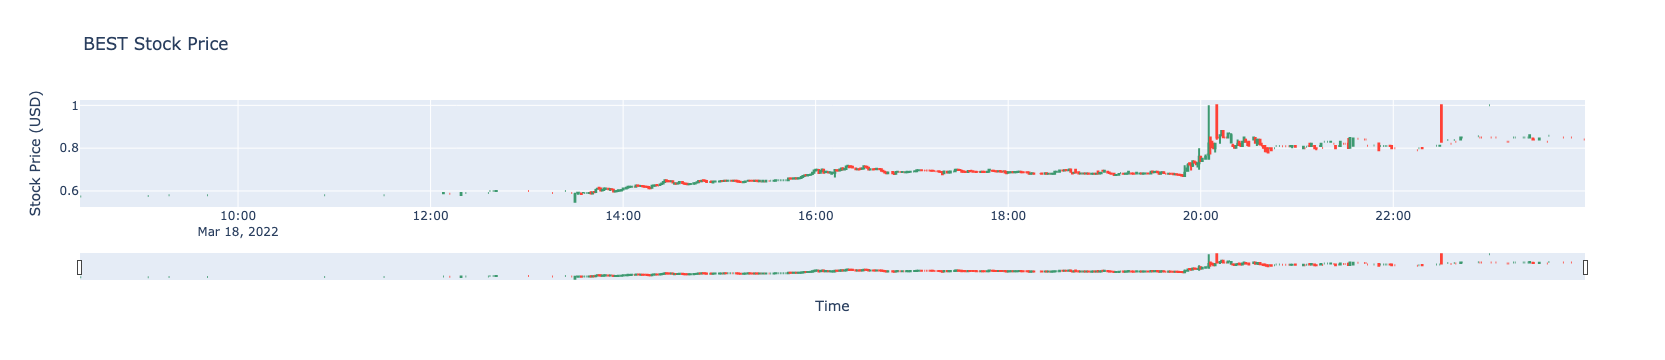

In [42]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [ ]:
# This was run including the TRF trades.  The notable difference is ignoring the the $1.0 trade reported at 21:05 but which took place earlier. The bars at 20:05, 20:10, and 22:30 seem related.
# https://polygon.io/blog/understanding-trade-eligibility

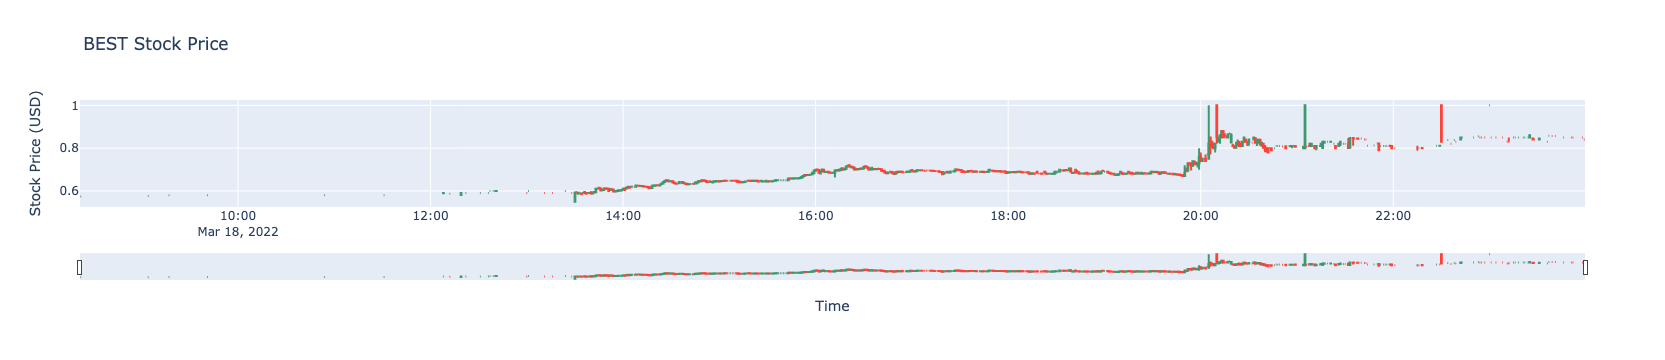

In [39]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

Earlier Pandas version.

In [236]:
def label_ticker_session(df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    # df.info()
    df = df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


def label_ticker_day_aggs(df: pd.DataFrame, schedule: pd.Series):
    pre_df = label_ticker_session(df, start=schedule['pre'], end=schedule['market_open'] - pd.Timedelta(seconds=60))
    market_df = label_ticker_session(df, start=schedule['market_open'], end=schedule['market_close'] - pd.Timedelta(seconds=60))
    post_df = label_ticker_session(df, start=schedule['market_close'], end=schedule['post'] - pd.Timedelta(seconds=60))
    return pd.concat([pre_df, market_df, post_df])


def label_custom_aggs_for_date(date, sessions, fragment):
    def label_custom_aggs(df: pd.DataFrame):
        # ticker = df.iloc[0]['ticker']
        # df = df.drop(columns=['ticker'])
        df = df.set_index('window_start').sort_index()
        # df = df.set_index('window_start')
        # df.info()
        df = label_ticker_day_aggs(df, sessions)
        # df['ticker'] = ticker
        return df
    
    aggs_table = fragment.to_table()
    aggs_df = aggs_table.to_pandas()
    aggs_df.set_index('ticker', inplace=True)
    aggs_df.sort_index(inplace=True)
    labeled_aggs_dfs = aggs_df.groupby('ticker').apply(label_custom_aggs)
    labeled_aggs_dfs.info()
    print(labeled_aggs_dfs)


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post",
                                 tz='US/Eastern')
    for date, sessions in schedule.iterrows():
        print(f"{date=} {sessions=}")
        filter_expr = (pc.field('year') == date.year) & (pc.field('month') == date.month) & (pc.field('date') == date.to_pydatetime().date())
        print(f"{filter_expr=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        for fragment in aggs_ds.get_fragments(filter=filter_expr):
            label_custom_aggs_for_date(date, sessions, fragment)

In [238]:
config.start_date = '2024-12-05'
config.end_date = '2024-12-05'
label_custom_aggs_ds(config)

date=Timestamp('2024-12-05 00:00:00') sessions=pre            2024-12-05 04:00:00-05:00
market_open    2024-12-05 09:30:00-05:00
market_close   2024-12-05 16:00:00-05:00
post           2024-12-05 20:00:00-05:00
Name: 2024-12-05 00:00:00, dtype: datetime64[ns, US/Eastern]
filter_expr=<pyarrow.compute.Expression (((year == 2024) and (month == 12)) and (date == 2024-12-05))>
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6425354 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZZZ', Timestamp('2024-12-05 21:00:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   open              float64
 1   high              float64
 2   low               float64
 3   close             float64
 4   volume            float64
 5   transactions      float64
 6   gain_from_open    float64
 7   fwd_1h_min_low    float64
 8   fwd_1h_max_close  float64
 9   gain_1h           float64
 10  loss_1h           float64
dtypes: